In [2]:
import torch
import pandas
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn, Tensor
from IPython import display
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor

%matplotlib inline

In [3]:
class ResBlock(nn.Module):
    def __init__(
        self,
        inputChannel: int,
        outputChannel: int,
        stride: int = 1,
        isUseConvolution: bool = False,
    ) -> None:
        """
        Arguments:
            inputChannel:       tell the input channel of inputX
            outputChannel:      tell the output channel of inputX
            stride:             if the stride == 2, the weight should be cut into half shape of origin inputX
            isUseConvolution:   use the 1 * 1 Convolution to transfor the inputX's channel into outputChannel
        """

        super(ResBlock, self).__init__()

        self.__type_name__ = "Resnet Block"

        self.conv1 = nn.Conv2d(inputChannel, outputChannel, 3, stride, 1)

        self.conv2 = nn.Conv2d(outputChannel, outputChannel, 3, 1, 1)

        if isUseConvolution:
            self.conv3 = nn.Conv2d(inputChannel, outputChannel, 1, stride)
        else:
            self.conv3 = None

        self.bn1 = nn.BatchNorm2d(outputChannel)
        self.bn2 = nn.BatchNorm2d(outputChannel)

    def forward(self, inputs) -> Tensor:
        """
        from top to btn
        Input Data
            |
        Convoluton(3 * 3)
            |
        Activation ReLU
            |
        Batch Normalization
            |
        Convolution(3 * 3)
            |
        Batch Normalization
            |
        Activation ReLU = f(Input Data) + O
        """

        Y = self.bn1(F.relu(self.conv1(inputs)))
        Y = self.bn2(self.conv2(Y))
        # if haven't set the 1*1 convolution, F(x) = x + g(x)
        if self.conv3:
            inputs = self.conv3(inputs)

        Y += inputs

        return F.relu(Y)

In [4]:
# data = torch.rand(1, 1, 28, 28)
# bt1 = ResBlock(1, 10, 2, True)
# bt2 = ResBlock(10, 10)

# data = bt1(data)
# data.shape
# data = bt2(data)
# data.shape

# bt1 = ResBlock(10, 20, 2, True)
# data = bt1(data)
# data.shape




In [5]:
# class Network(nn.Module):
#     """
#     Arg:
#         inputChannel:   The input depth of image
#         labelNum:       classify
#     """

#     def __init__(
#         self,
#         inputChannel: int,
#         labelNum: int,
#         layerNum: int,
#     ) -> None:
#         super().__init__()

#         # weight: weight / 2; height: height * 2;[1, 28, 28] => [2, 14, 14]
#         self.inputLayer = ResBlock(
#             inputChannel,
#             inputChannel * 2,
#             2,
#             True,
#         )

#         self.layers = []

#         # do not change the weight and height
#         for i in range(layerNum):
#             self.layers.append(ResBlock(inputChannel * 2, inputChannel * 2))

#         self.outputLayer = nn.Linear(2 * 14 * 14, labelNum)

#         self.model = nn.Sequential(
#             self.inputLayer,
#             *self.layers,
#             nn.AdaptiveAvgPool2d((1, 1)),
#             nn.Flatten(),
#             self.outputLayer,
#         )

#     def forward(self, inputs):
#         return self.model(inputs)

In [6]:
def CreateResBlok(
    layerNum: int,
    isFirstBlock: bool,
    inputChannel: int,
    outputChannel: int,
) -> list:
    block = []

    # when the first block, we change the width -> width / 2; channel -> channel * 2
    for i in range(layerNum):
        if i == 0 or isFirstBlock:
            block.append(ResBlock(inputChannel, outputChannel, 2, True))
        else:
            block.append(ResBlock(outputChannel, outputChannel))

    return block

In [7]:
def InstanceModel():
    # (1, 28, 28) -> (16, 14, 14)
    layer1 = CreateResBlok(3, False, 1, 16)
    # (16, 14, 14) -> (32, 7, 7)
    layer2 = CreateResBlok(3, False, 16, 32)

    outputLayer = nn.Linear(32 * 7 * 7, 10)

    model = nn.Sequential(*layer1, *layer2, nn.Flatten(), outputLayer)

    return model

In [8]:
DATA = datasets.MNIST(
    root="../Database", train=True, download=False, transform=ToTensor()
)

In [9]:
BATCHSIZE = 64
LR = 1e-3

model = InstanceModel()
optimizer = torch.optim.Adam(model.parameters(), LR)
lossFunction = nn.CrossEntropyLoss()

In [10]:
data = torch.rand(1, 1, 28, 28)

for layer in model:
    data = layer(data)
    print(data.shape)

torch.Size([1, 16, 14, 14])
torch.Size([1, 16, 14, 14])
torch.Size([1, 16, 14, 14])
torch.Size([1, 32, 7, 7])
torch.Size([1, 32, 7, 7])
torch.Size([1, 32, 7, 7])
torch.Size([1, 1568])
torch.Size([1, 10])


In [11]:
trainData, testData = random_split(
    DATA, lengths=[int(len(DATA) * 0.01), int(len(DATA) * 0.99)]
)
trainData = DataLoader(trainData, batch_size=BATCHSIZE)

In [12]:
history = {
    'loss': [],   
}

In [14]:
for i in range(10):
    runtimeLoss = 0.0
    for index, data in enumerate(trainData):
        img, label = data

        optimizer.zero_grad()
        outputs = model(img)

        loss = lossFunction(outputs, label)
        loss.backward()
        optimizer.step()

        runtimeLoss += loss.data
    history['loss'].append(runtimeLoss)

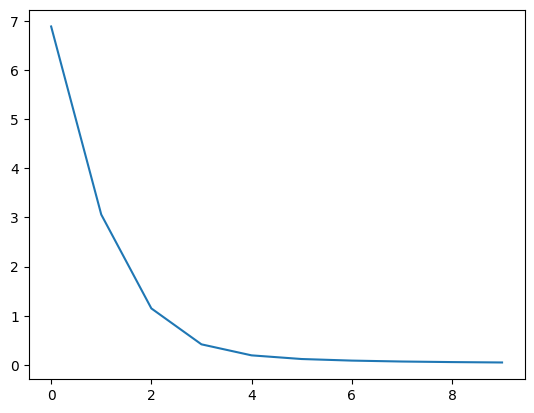

In [15]:
plt.plot(history['loss'])